In [1]:
import imma
import imma.volumetry_evaluation
import io3d
import io3d.datasets
import numpy as np
import matplotlib.pyplot as plt
import skimage.morphology

PyQt5 detected


# Ground true segmentation

In [2]:
io3d.datasets.DATASET_PATH_STRUCTURE.keys()

dict_keys(['3Dircadb1', 'sliver07', 'pilsen_pigs'])

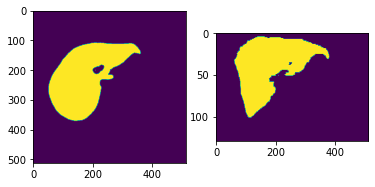

In [3]:
# dp_data3d = io3d.read_dataset("3Dircadb1",'data3d', 1)
dp_liver = io3d.read_dataset("3Dircadb1",'liver', 1)
fig, axs = plt.subplots(1, 2)
axs[0].imshow(dp_liver.data3d[50,:,:])
axs[1].imshow(dp_liver.data3d[:,200,:], aspect=dp_liver.voxelsize_mm[0]/dp_liver.voxelsize_mm[1])

# Fake segmentation

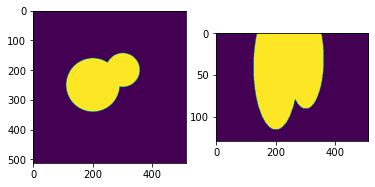

In [5]:
# fake_segmentation = np.zeros_like(dp_liver.data3d)

center = [40, 300, 200]
r = 30

sh = dp_liver.data3d.shape
def make_sphere(r, center, shape):
    sh = shape
    xx,yy,zz = np.meshgrid(list(range(sh[0])), list(range(sh[1])), list(range(sh[2])), indexing='ij')
    fake_segmentation = (xx-center[0])**2 + (yy-center[1])**2 + (zz-center[2])**2 - r**2
    return fake_segmentation < 0
#     return np.sqrt(np.abs(fake_segmentation)) * np.sign(fake_segmentation)

sph = make_sphere(90, [40, 250, 200], sh)
sph += make_sphere(60, [30, 200, 300], sh)

fake_segmentation = sph

 # fake_segmentation = skimage.morphology.ball(30)
# plt.imshow(fake_segmentation[40,:,:])
fig, axs = plt.subplots(1, 2)
axs[0].imshow(fake_segmentation[50,:,:])
axs[1].imshow(fake_segmentation[:,200,:], aspect=dp_liver.voxelsize_mm[0]/dp_liver.voxelsize_mm[1])


# Evaluation

Described in paper

Heimann, T., van Ginneken, B., Styner, M. a, Arzhaeva, Y., Aurich, V., Bauer, C., … Wolf, I. (2009). Comparison and evaluation of methods for liver segmentation from CT datasets. IEEE Transactions on Medical Imaging, 28(8), 1251–1265. https://doi.org/10.1109/TMI.2009.2013851

## General metrics independent on volume type

`compare_volumes(ground_true, segmentation, voxelsize_mm)`

* `volume1_mm3`: Ground True volume in [mm^3]
* `volume2_mm3`: Volume of segmentation in [mm^3]
* `err1_mm3`: undersegmentation
* `err2_mm3`: oversegmentation
* `err1_percent`: undersegmentation in [%]
* `err2_percent`: oversegmentation in [%]
* `vd`: Volume difference, negative is means smaller volume of segmentation than ground true
* `voe`: Volumetric Error
* `avgd`: Average surface difference




In [6]:
evaluation = imma.volumetry_evaluation.compare_volumes(dp_liver.data3d, fake_segmentation, voxelsize_mm=dp_liver.voxelsize_mm)
evaluation

{'volume1_mm3': 1489409.6838546782,
 'volume2_mm3': 1619329.1350100804,
 'err1_mm3': 760856.530482664,
 'err2_mm3': 890775.9816380662,
 'err1_percent': 48.94953064989304,
 'err2_percent': 57.30786878798377,
 'vd': 8.722882129996849,
 'voe': 69.39091080438091,
 'avgd': 20.761735595187776,
 'rmsd': 624.7126257039051,
 'maxd': 72.15508355688652,
 'dice': 0.5312869971893841,
 'jaccard': 0.30609089195619094}

## Metrics recalculated to the points accoarding to human performance on liver segmentation

For more detail see the paper.

In [7]:
evaluation, diff = imma.volumetry_evaluation.compare_volumes_sliver(dp_liver.data3d, fake_segmentation, voxelsize_mm=dp_liver.voxelsize_mm, return_diff=True)
evaluation

{'volume1_mm3': 1489409.6838546782,
 'volume2_mm3': 1619329.1350100804,
 'err1_mm3': 760856.530482664,
 'err2_mm3': 890775.9816380662,
 'err1_percent': 48.94953064989304,
 'err2_percent': 57.30786878798377,
 'vd': 8.722882129996849,
 'voe': 69.39091080438091,
 'avgd': 20.761735595187776,
 'rmsd': 624.7126257039051,
 'maxd': 72.15508355688652,
 'dice': 0.5312869971893841,
 'jaccard': 0.30609089195619094,
 'sliver_vd_pts': 65.92624167969981,
 'sliver_voe_pts': 0,
 'sliver_avgd_pts': 0,
 'sliver_rmsd_pts': 0,
 'sliver_maxd_pts': 5.059100583044085,
 'sliver_overall_pts': 14.19706845254878}

## See the difference

* red - undersegmentation
* blue - over segmentation

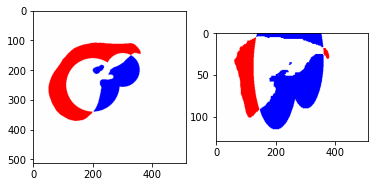

In [8]:
fig, axs = plt.subplots(1, 2)
axs[0].imshow(diff[50,:,:], cmap="bwr")
axs[1].imshow(diff[:,200,:], aspect=dp_liver.voxelsize_mm[0]/dp_liver.voxelsize_mm[1], cmap='bwr')

## Interactive visualization of difference

In [27]:
np.unique(diff, return_counts=True)

(array([-1,  0,  1], dtype=int8),
 array([ 1713558, 30639382,  1463636], dtype=int64))

In [14]:
dp_data3d = io3d.read_dataset("3Dircadb1",'data3d', 1)

In [29]:
# 0 - transparent, 1,2,3,4 are colored
seeds = diff.copy()
seeds[seeds==-1] = 2

import sed3
sed3.ipy_show_slices(
    dp_data3d.data3d, 
    contour=dp_liver.data3d, # Ground True segmentation 
    seeds=seeds, # with full color
)

interactive(children=(IntSlider(value=0, continuous_update=False, description='slice_number', max=128), IntSli…

<function sed3.sed3.ipy_show_slices.<locals>.nbw_show_slices_fcn(image, slice_number, contour, seeds, axis)>

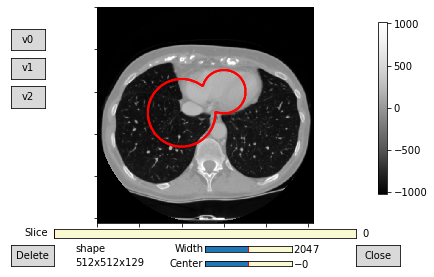

In [26]:
# %matplotlib gtk
ed = sed3.sed3(dp_data3d.data3d, contour=diff)
seeds = ed.show()